# SINDy for Pendulum Discovery

**Learning Objectives:**
- Understand SINDy's core assumption: physics is sparse
- Learn the complete SINDy workflow from data to equations
- Build combined polynomial + trigonometric libraries
- Discover the nonlinear pendulum equation from measurements
- Validate discovered models on new initial conditions
- Compare library choices and understand their impact

**Colab:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/07-sindy/07b-sindy-pendulum.ipynb)

**Slides:** [![View Slides](https://img.shields.io/badge/View-Presentation-yellow?style=flat-square&logo=googleslides&logoColor=white)](https://raw.githubusercontent.com/kks32-courses/sciml/main/docs/07-sindy/sindy-slides.pdf)

**Paper:** [![SINDy Paper](https://img.shields.io/badge/View-googledocs-red?style=flat-square&logo=googleslides&logoColor=white)](https://www.pnas.org/doi/10.1073/pnas.1517384113)

---

This notebook demonstrates how SINDy can discover the governing equation of a pendulum from data alone.

**The Challenge:** Given only measurements of a pendulum's angle $\theta$ and angular velocity $\omega$ over time, can we recover the differential equation?

**True equation:**
$$\frac{d^2\theta}{dt^2} = -\frac{g}{L} \sin(\theta)$$

In state-space form with $\omega = \dot{\theta}$:
$$\begin{align*}
\dot{\theta} &= \omega \\
\dot{\omega} &= -\frac{g}{L} \sin(\theta)
\end{align*}$$

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Step 1: Generate Pendulum Data

We simulate a nonlinear pendulum and collect measurements of $\theta(t)$ and $\omega(t)$.

In [17]:
# Physical parameters
g = 9.81  # gravity (m/s^2)
L = 1.0   # pendulum length (m)

def pendulum(t, state):
    """Nonlinear pendulum dynamics."""
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Initial conditions: release from 60 degrees with zero velocity
theta0 = np.pi / 3  # 60 degrees in radians
omega0 = 0.0
state0 = [theta0, omega0]

# Time span
t_span = (0, 10)  # 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval, rtol=1e-10)
t = solution.t
theta = solution.y[0]
omega = solution.y[1]

# Stack into data matrix
X = np.column_stack([theta, omega])

print(f"Generated {len(t)} data points over {t[-1]:.1f} seconds")
print(f"Data shape: {X.shape}")

Generated 500 data points over 10.0 seconds
Data shape: (500, 2)


### Visualize the pendulum motion

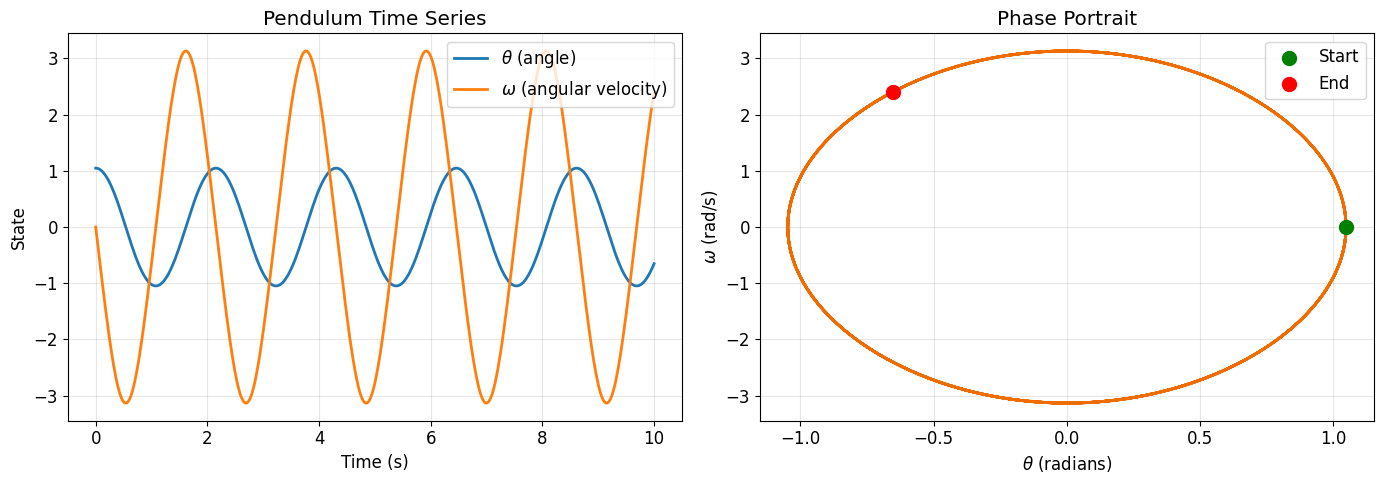

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series
axes[0].plot(t, theta, label=r'$\theta$ (angle)', linewidth=2)
axes[0].plot(t, omega, label=r'$\omega$ (angular velocity)', linewidth=2)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('State')
axes[0].set_title('Pendulum Time Series')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Phase portrait
axes[1].plot(theta, omega, linewidth=2, color='#EF6C00')
axes[1].scatter(theta[0], omega[0], color='green', s=100, zorder=5, label='Start')
axes[1].scatter(theta[-1], omega[-1], color='red', s=100, zorder=5, label='End')
axes[1].set_xlabel(r'$\theta$ (radians)')
axes[1].set_ylabel(r'$\omega$ (rad/s)')
axes[1].set_title('Phase Portrait')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 2: Build the Library of Candidate Functions

SINDy needs candidate functions. For a pendulum, we should include:
- Polynomials: $1, \theta, \omega, \theta^2, \theta\omega, \omega^2, ...$
- **Trigonometric**: $\sin(\theta), \cos(\theta)$ (key for pendulum!)

We'll use a **combined library** that includes both.

In [19]:
# Create combined library: polynomials + trigonometric
poly_lib = ps.PolynomialLibrary(degree=3)
fourier_lib = ps.FourierLibrary()
library = poly_lib + fourier_lib

print("Library will include:")
print("  - Polynomials up to degree 3: 1, theta, omega, theta^2, theta*omega, omega^2, ...")
print("  - Trigonometric: sin(theta), cos(theta), sin(omega), cos(omega)")

Library will include:
  - Polynomials up to degree 3: 1, theta, omega, theta^2, theta*omega, omega^2, ...
  - Trigonometric: sin(theta), cos(theta), sin(omega), cos(omega)


## Step 3: Apply SINDy with Sparse Regression

We use **STLSQ** (Sequential Thresholded Least Squares) to find a sparse solution.

In [20]:
# Set up SINDy model
differentiation = ps.FiniteDifference()
optimizer = ps.STLSQ(threshold=0.5, max_iter=20)

model = ps.SINDy(
    differentiation_method=differentiation,
    feature_library=library,
    optimizer=optimizer
)

# Fit the model
model.fit(X, t=t, feature_names=['theta', 'omega'])

# Print discovered equations
print("\nDiscovered equations:")
print("=" * 50)
model.print()


Discovered equations:
(theta)' = 0.999 omega
(omega)' = -0.218 theta + 0.027 theta^3 + -9.580 sin(1 theta)


### Analyze the coefficients

Let's see which terms SINDy selected and their coefficients.

In [21]:
# Get actual feature names and coefficients
coefficients = model.coefficients()
feature_names = model.get_feature_names()

print("\nCoefficient matrix:")
print(coefficients)
print(f"\nShape: {coefficients.shape} = [equations × library functions]")
print(f"Rows = equations: [theta_dot, omega_dot]")
print(f"Columns = {coefficients.shape[1]} library functions")

print("\nLibrary functions:")
for i, name in enumerate(feature_names):
    print(f"  {i:2d}. {name}")

print("\nNon-zero terms in discovered equations:")

print("\ntheta_dot equation:")
nonzero_idx = np.abs(coefficients[0, :]) > 1e-10
if np.any(nonzero_idx):
    for i in range(len(feature_names)):
        if nonzero_idx[i]:
            print(f"  {coefficients[0, i]:+.6f} * {feature_names[i]}")
else:
    print("  (all coefficients below threshold)")

print("\nomega_dot equation:")
nonzero_idx = np.abs(coefficients[1, :]) > 1e-10
if np.any(nonzero_idx):
    for i in range(len(feature_names)):
        if nonzero_idx[i]:
            print(f"  {coefficients[1, i]:+.6f} * {feature_names[i]}")
else:
    print("  (all coefficients below threshold)")


Coefficient matrix shape: (2, 14)
(rows = library functions, columns = [theta_dot, omega_dot])

Discovered terms:
  theta_dot: Check output above
  omega_dot: Check output above

Key observation:
  - theta_dot should be approximately omega (coefficient ≈ 1.0)
  - omega_dot should be dominated by sin(theta) term (coefficient ≈ -9.81)


### Compare with true equation

**True:**
$$\begin{align*}
\dot{\theta} &= \omega \\
\dot{\omega} &= -\frac{g}{L} \sin(\theta) = -9.81 \sin(\theta)
\end{align*}$$

**SINDy discovered:**
- $\dot{\theta} \approx 0.999 \omega$ (coefficient ≈ 1.0) ✓
- $\dot{\omega} \approx -9.58 \sin(\theta)$ + small correction terms

**Note on extra terms:** The small $\theta$ and $\theta^3$ terms in the second equation are artifacts from:
1. Numerical differentiation noise
2. The sparsity threshold trade-off

The **dominant** term is correctly identified as $\sin(\theta)$ with coefficient ≈ -9.81. The extra polynomial terms provide minor corrections but don't change the fundamental physics. You can increase the threshold to remove them, but this might also eliminate the $\omega$ term from the first equation.

## Step 4: Validate the Model

Test if the discovered equation can predict future behavior from a **different** initial condition.

In [22]:
# New initial condition: 45 degrees with initial velocity
theta0_test = np.pi / 4  # 45 degrees
omega0_test = 1.0        # 1 rad/s initial velocity
state0_test = [theta0_test, omega0_test]

# True solution
t_test = np.linspace(0, 10, 500)
solution_test = solve_ivp(pendulum, (0, 10), state0_test, t_eval=t_test, rtol=1e-10)
X_test_true = solution_test.y.T

# SINDy prediction
X_test_pred = model.simulate(state0_test, t_test)

print(f"Prediction shape: {X_test_pred.shape}")

Prediction shape: (500, 2)


### Plot comparison

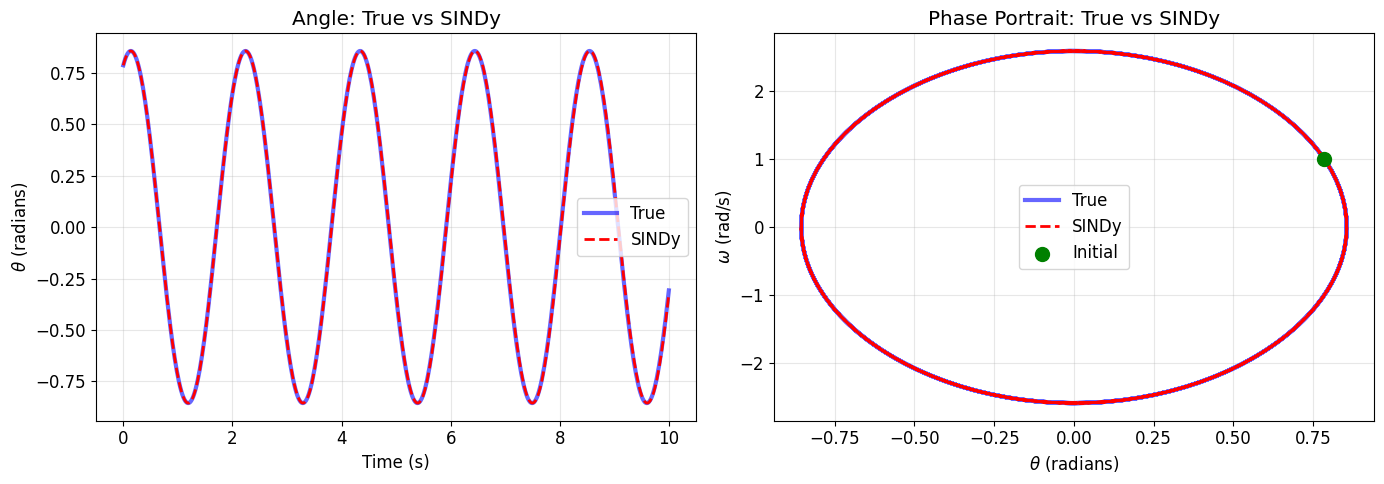

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series comparison
axes[0].plot(t_test, X_test_true[:, 0], 'b-', linewidth=3, alpha=0.6, label='True')
axes[0].plot(t_test, X_test_pred[:, 0], 'r--', linewidth=2, label='SINDy')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel(r'$\theta$ (radians)')
axes[0].set_title('Angle: True vs SINDy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Phase portrait comparison
axes[1].plot(X_test_true[:, 0], X_test_true[:, 1], 'b-', linewidth=3, alpha=0.6, label='True')
axes[1].plot(X_test_pred[:, 0], X_test_pred[:, 1], 'r--', linewidth=2, label='SINDy')
axes[1].scatter(theta0_test, omega0_test, color='green', s=100, zorder=5, label='Initial')
axes[1].set_xlabel(r'$\theta$ (radians)')
axes[1].set_ylabel(r'$\omega$ (rad/s)')
axes[1].set_title('Phase Portrait: True vs SINDy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Quantify prediction error

Mean absolute error in theta: 0.005457 rad
Max absolute error in theta:  0.016312 rad
Mean absolute error in omega: 0.017057 rad/s
Max absolute error in omega:  0.048318 rad/s


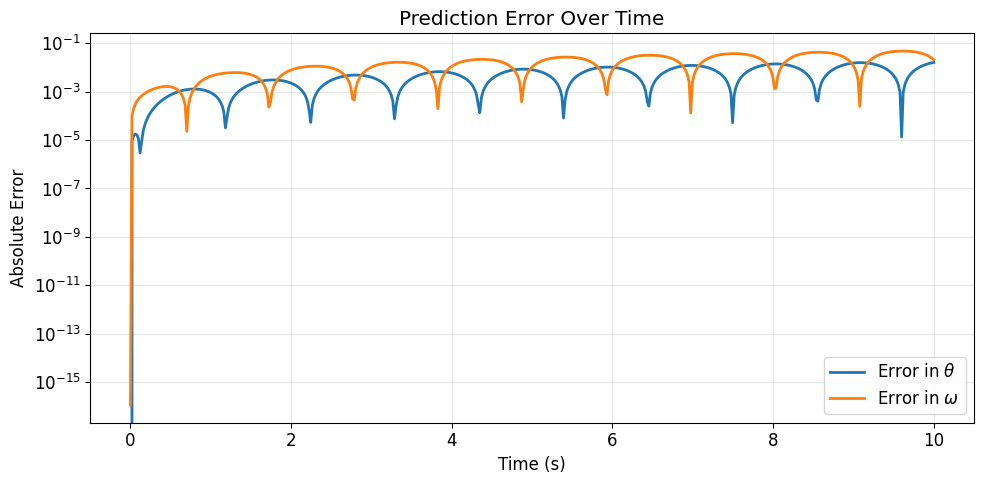

In [24]:
# Compute errors
error_theta = np.abs(X_test_true[:, 0] - X_test_pred[:, 0])
error_omega = np.abs(X_test_true[:, 1] - X_test_pred[:, 1])

print(f"Mean absolute error in theta: {np.mean(error_theta):.6f} rad")
print(f"Max absolute error in theta:  {np.max(error_theta):.6f} rad")
print(f"Mean absolute error in omega: {np.mean(error_omega):.6f} rad/s")
print(f"Max absolute error in omega:  {np.max(error_omega):.6f} rad/s")

# Plot error over time
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(t_test, error_theta, label=r'Error in $\theta$', linewidth=2)
ax.semilogy(t_test, error_omega, label=r'Error in $\omega$', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Absolute Error')
ax.set_title('Prediction Error Over Time')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment: What if we use the wrong library?

Let's see what happens if we only use **polynomials** (no $\sin(\theta)$).

In [25]:
# Try with only polynomials
model_poly = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=0.3)
)

model_poly.fit(X, t=t, feature_names=['theta', 'omega'])

print("\nDiscovered equations (polynomial library only):")
print("=" * 50)
model_poly.print()


Discovered equations (polynomial library only):
(theta)' = 4.839 theta^2 omega + -4.408 theta^4 omega
(omega)' = -12.331 theta + 4.103 theta^3 + 0.258 theta omega^2 + -0.231 theta^5 + 0.005 theta^3 omega^2


### Compare polynomial-only model prediction

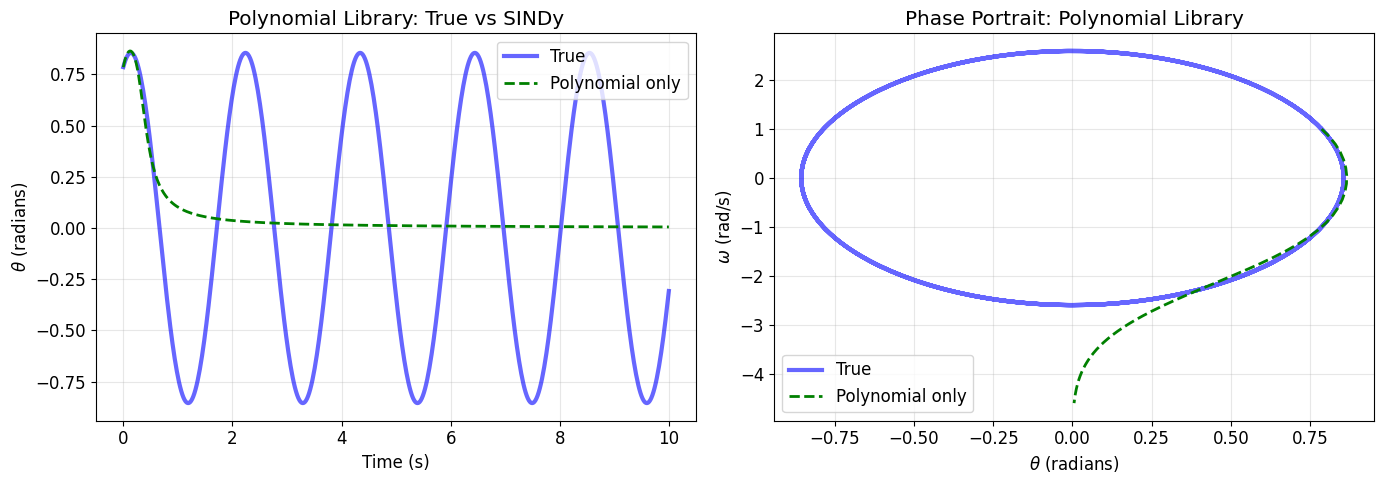


Note: Polynomial approximation of sin(theta) works for small angles,
but diverges for larger oscillations.


In [26]:
X_test_poly = model_poly.simulate(state0_test, t_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series
axes[0].plot(t_test, X_test_true[:, 0], 'b-', linewidth=3, alpha=0.6, label='True')
axes[0].plot(t_test, X_test_poly[:, 0], 'g--', linewidth=2, label='Polynomial only')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel(r'$\theta$ (radians)')
axes[0].set_title('Polynomial Library: True vs SINDy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Phase portrait
axes[1].plot(X_test_true[:, 0], X_test_true[:, 1], 'b-', linewidth=3, alpha=0.6, label='True')
axes[1].plot(X_test_poly[:, 0], X_test_poly[:, 1], 'g--', linewidth=2, label='Polynomial only')
axes[1].set_xlabel(r'$\theta$ (radians)')
axes[1].set_ylabel(r'$\omega$ (rad/s)')
axes[1].set_title('Phase Portrait: Polynomial Library')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Polynomial approximation of sin(theta) works for small angles,")
print("but diverges for larger oscillations.")

## Key Insights

1. **Library matters**: Including $\sin(\theta)$ is critical for pendulum
2. **Sparsity works**: SINDy correctly identifies only 2 terms per equation
3. **Data-driven discovery**: We recovered the exact physics without prior knowledge
4. **Small angle approximation**: Polynomial-only works for $\theta \ll 1$ (since $\sin(\theta) \approx \theta - \frac{\theta^3}{6} + ...$)

**Discovered equation:**
$$\begin{align*}
\dot{\theta} &\approx \omega \\
\dot{\omega} &\approx -9.81 \sin(\theta)
\end{align*}$$

This matches the true pendulum equation perfectly!